In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Distribution phase CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
            previous_1d      EMA_12   willr_14        OBV_7  labels
D

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

distribution phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2006-10-09    73.690002  71.134420 -19.770359  72131900.0     2.0
2006-10-10    74.919998  71.716816 -14.583357  74465400.0     2.0
2006-10-11    75.080002  72.234229 -12.622528  76502600.0     2.0
2006-10-12    75.500000  72.736656  -7.475494  78673900.0     2.0
2006-10-13    76.699997  73.346400  -0.000000  80474900.0     2.0


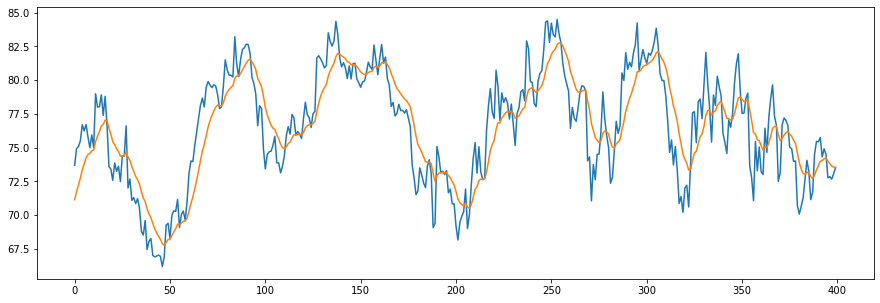

distribution phase data\10_acc_data.csv
            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2009-09-07     5.523615  5.253749  -2.083310  2.905368e+10     2.0
2009-09-08     5.670780  5.317908  -1.587284  2.963190e+10     2.0
2009-09-09     5.778702  5.388799  -1.351401  3.022740e+10     2.0
2009-09-10     5.670780  5.432181 -17.333390  2.996536e+10     2.0
2009-09-11     5.798324  5.488511  -7.407383  3.040677e+10     2.0


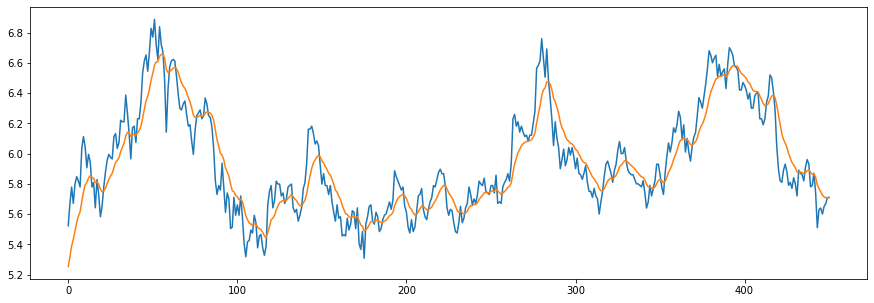

distribution phase data\11_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2013-07-01    15.470000  15.294561 -17.605633  1.538258e+09     2.0
2013-07-02    15.740000  15.363090  -3.355718  1.574270e+09     2.0
2013-07-03    16.180000  15.488768  -1.570618  1.644546e+09     2.0
2013-07-05    16.430000  15.633573  -0.930254  1.682660e+09     2.0
2013-07-08    16.700001  15.797639  -1.639304  1.727389e+09     2.0


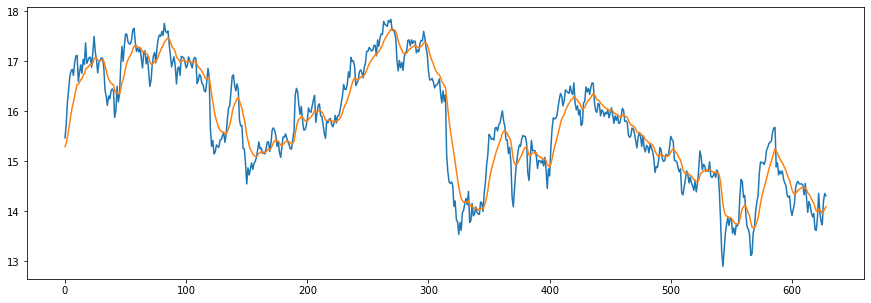

distribution phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2006-11-13    85.620003  82.836797 -14.766554  210361300.0     2.0
2006-11-14    85.690002  83.275752 -14.006514  213721400.0     2.0
2006-11-15    85.739998  83.654867 -13.463676  217184500.0     2.0
2006-11-16    87.080002  84.181810  -5.518761  223035400.0     2.0
2006-11-17    88.709999  84.878455  -6.976756  230002300.0     2.0


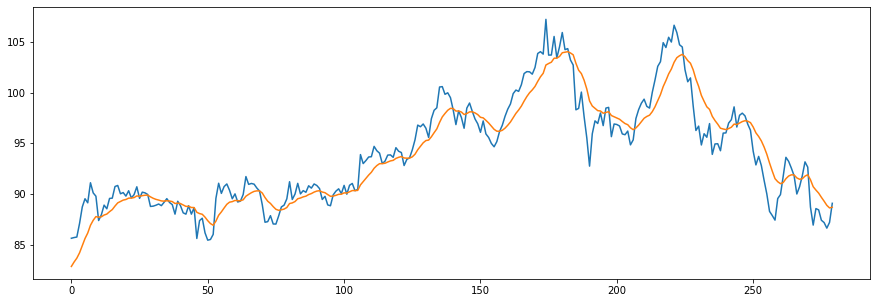

distribution phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2017-05-22    28.480000  27.904435 -21.238934  1.403863e+10     2.0
2017-05-23    28.790001  28.040676  -7.870286  1.406287e+10     2.0
2017-05-24    29.230000  28.223649  -2.409692  1.409594e+10     2.0
2017-05-25    29.400000  28.404626  -5.109533  1.412556e+10     2.0
2017-05-26    29.340000  28.548530  -7.299293  1.410324e+10     2.0


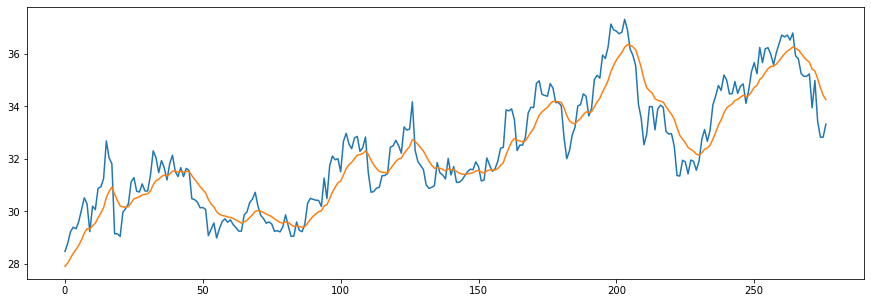

distribution phase data\3_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2014-11-17        10.24  10.065352  -0.000000  374065465.0     2.0
2014-11-18        10.19  10.084529  -8.333373  371334465.0     2.0
2014-11-19        10.26  10.111524  -6.060602  374567465.0     0.0
2014-11-20        10.50  10.171290  -0.000000  385737465.0     2.0
2014-11-21        10.35  10.198784 -24.590115  381908465.0     2.0


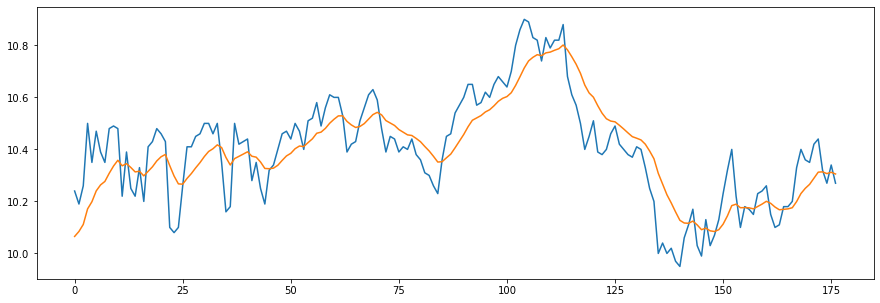

distribution phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2017-09-25    71.400002  69.968115 -12.288727  1.293695e+09     2.0
2017-09-26    70.839996  70.102250 -20.890964  1.282932e+09     2.0
2017-09-27    70.940002  70.231135 -19.354771  1.294486e+09     2.0
2017-09-28    72.279999  70.546345  -9.718346  1.312578e+09     2.0
2017-09-29    72.650002  70.869985  -4.848481  1.326424e+09     2.0


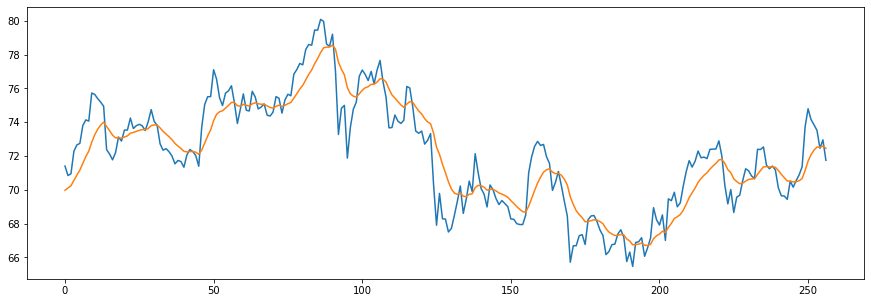

distribution phase data\5_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2009-08-03        13.50  13.432090 -36.956535  16473747.0     2.0
2009-08-04        13.74  13.479461 -11.363678  18073747.0     2.0
2009-08-05        13.54  13.488775 -36.585403  16633747.0     2.0
2009-08-06        13.54  13.496656 -36.585403  16633747.0     0.0
2009-08-07        13.84  13.549478  -0.000000  18804747.0     2.0


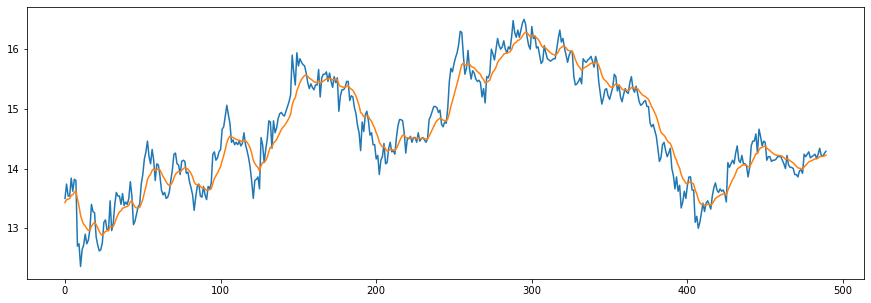

distribution phase data\6_acc_data.csv
            previous_1d      EMA_12  willr_14        OBV_7  labels
Date                                                              
2009-07-20   156.839996  149.595381 -5.052762 -269164300.0     2.0
2009-07-21   160.029999  151.200707 -2.745086 -256730500.0     2.0
2009-07-22   159.800003  152.523675 -3.647030 -267617000.0     2.0
2009-07-23   160.460007  153.744650 -3.036100 -258117600.0     0.0
2009-07-24   165.449997  155.545472 -3.109975 -245825700.0     2.0


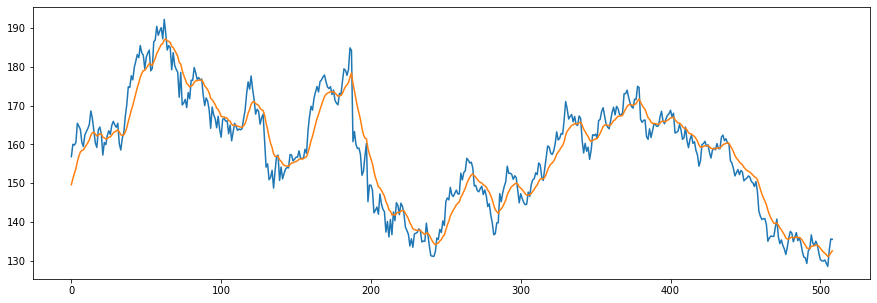

distribution phase data\7_acc_data.csv
            previous_1d      EMA_12  willr_14        OBV_7  labels
Date                                                              
2014-09-15   183.169998  179.474733 -3.957823 -307548600.0     2.0
2014-09-16   183.979996  180.167851 -4.935352 -305240600.0     2.0
2014-09-17   184.039993  180.763565 -5.997744 -303103000.0     2.0
2014-09-18   184.820007  181.387633 -9.615349 -300282700.0     0.0
2014-09-19   187.889999  182.387997 -4.572340 -296716100.0     2.0


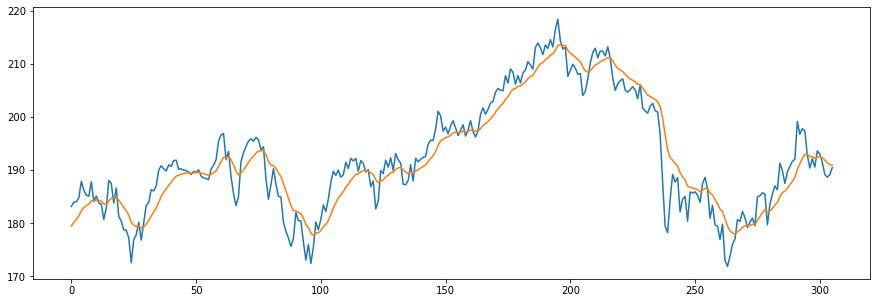

distribution phase data\8_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2010-11-01    16.059999  16.002080 -62.069028  9.662836e+09     2.0
2010-11-02    16.660000  16.103298 -10.344893  9.728221e+09     2.0
2010-11-03    16.879999  16.222791  -7.352971  9.772645e+09     2.0
2010-11-04    16.980000  16.339284 -12.820558  9.827731e+09     2.0
2010-11-05    17.000000  16.440933 -16.867503  9.878587e+09     2.0


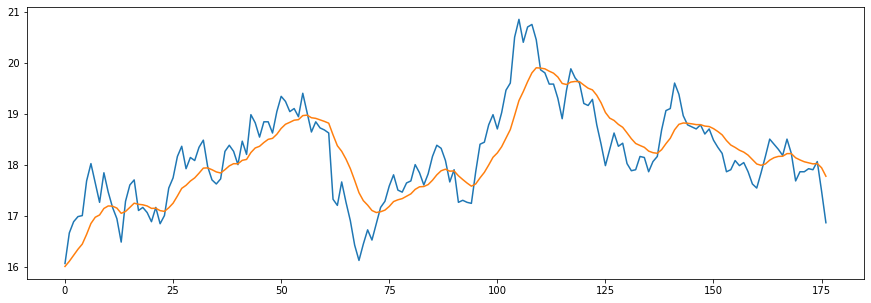

distribution phase data\9_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-01-08        12.16  11.454592  -1.333364  9.131847e+09     2.0
2018-01-09        12.00  11.538501 -22.352950  9.055020e+09     2.0
2018-01-10        12.02  11.612578 -21.176453  9.134387e+09     2.0
2018-01-11        12.22  11.706027 -14.117635  9.225876e+09     2.0
2018-01-12        12.20  11.782023 -15.294133  9.141718e+09     2.0


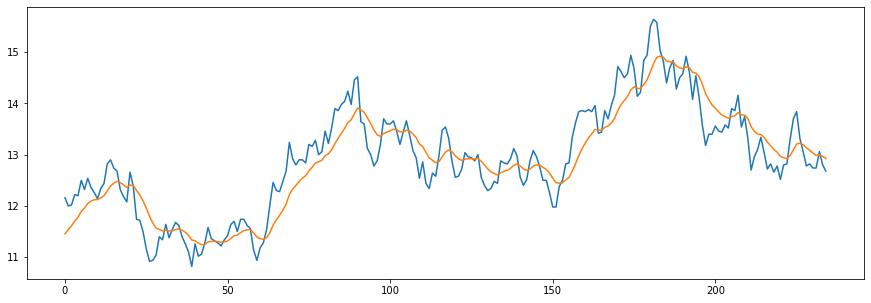

In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('distribution phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [10]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4020, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4020, 64, 64, 1)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 3643, 0.0: 181, 1.0: 196})

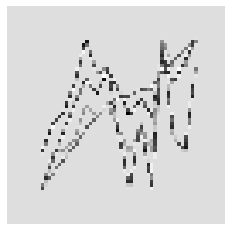

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.393103448275862, 1: 6.828025477707007, 2: 0.3678792038435141}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/26 [>.............................] - ETA: 0s - loss: 0.3827 - accuracy: 0.6797 - mse: 5.6401 - weighted_accuracy: 0.2962 - weighted_mse: 5.6566WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 26ms/step - loss: 0.2407 - accuracy: 0.3172 - mse: 1.6934 - weighted_accuracy: 0.3399 - weighted_mse: 1.7097 - val_loss: 0.2041 - val_accuracy: 0.0448 - val_mse: 1.0618 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 1.0618
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2056 - accuracy: 0.3075 - mse: 1.1794 - weighted_accuracy: 0.3513 - weighted_mse: 1.1699 - val_loss: 0.1921 - 

7/7 [==============================] - 0s 5ms/step - loss: 0.1805 - accuracy: 0.4749 - mse: 1.0948 - weighted_accuracy: 0.4749 - weighted_mse: 1.0948
Test loss: 0.18048323690891266
Test accuracy: 0.47488585114479065


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 104
actual holds but predicted sell: 0
actual predicted holds: 97
Percentage buys correct: 6.140350877192983%
Percentage sells correct: 0%
Percentage holds correct: 92.38095238095238%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 49.557522123893804%
Percentage high sells correct: 0%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256




Capital at the end of test period:

29/29 [==============================] - 0s 3ms/step - loss: 0.1807 - accuracy: 0.4482 - mse: 1.0921 - weighted_accuracy: 0.4482 - weighted_mse: 1.0921
Test loss: 0.18069134652614594
Test accuracy: 0.44820064306259155


number of predictions: 917
actual predicted buys: 29
actual buys but predicted sell: 0
actual buys but predicted hold: 17
actual sells but predicted buy: 11
actual predicted sells: 0
actual sells but predicted hold: 29
actual holds but predicted buy: 449
actual holds but predicted sell: 0
actual predicted holds: 382
Percentage buys correct: 5.930470347648262%
Percentage sells correct: 0%
Percentage holds correct: 89.25233644859813%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 45.28688524590164%
Percentage high sells correct: 0%
Percentage mid holds correct: 84.57943925233644%


Capital: 100
Share price: $0.3088084010225731
Shares owned at the moment: 322
Cash capital at the moment: $0.2902450316259575




Capital at the end of test p

Epoch 20/20
26/26 [==============================] - 0s 16ms/step - loss: 0.1877 - accuracy: 0.3001 - mse: 1.2266 - weighted_accuracy: 0.4749 - weighted_mse: 1.2229 - val_loss: 0.1888 - val_accuracy: 0.2923 - val_mse: 0.9674 - val_weighted_accuracy: 0.2923 - val_weighted_mse: 0.9674
Validation loss: 0.18879938125610352
Validation accuracy: 0.29228857159614563


accumulation phase data


8/8 [==============================] - 0s 3ms/step - loss: 0.1889 - accuracy: 0.2742 - mse: 0.9650 - weighted_accuracy: 0.2742 - weighted_mse: 0.9650
Test loss: 0.1888844519853592
Test accuracy: 0.27419355511665344


number of predictions: 248
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 85
actual holds but predicted sell: 87
actual predicted holds: 57
Percentage buys correct: 7.446808510638298%
Percentage sells correct: 4.39560439

15/15 [==============================] - 0s 3ms/step - loss: 0.1887 - accuracy: 0.2851 - mse: 0.9774 - weighted_accuracy: 0.2851 - weighted_mse: 0.9774
Test loss: 0.18869668245315552
Test accuracy: 0.2851063907146454


number of predictions: 470
actual predicted buys: 15
actual buys but predicted sell: 3
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 11
actual sells but predicted hold: 7
actual holds but predicted buy: 178
actual holds but predicted sell: 140
actual predicted holds: 108
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 89.25619834710744%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 50.76923076923077%
Percentage high sells correct: 48.36601307189542%
Percentage mid holds correct: 80.16528925619835%


Capital: 100
Share price: $0.5051713785101153
Shares owned at the moment: 197
Cash capital at the moment: $0.20756183919942828

9/9 [==============================] - 0s 5ms/step - loss: 0.1882 - accuracy: 0.2842 - mse: 0.9830 - weighted_accuracy: 0.2842 - weighted_mse: 0.9830
Test loss: 0.18823906779289246
Test accuracy: 0.2841726541519165


number of predictions: 278
actual predicted buys: 11
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 123
actual holds but predicted sell: 66
actual predicted holds: 60
Percentage buys correct: 8.02919708029197%
Percentage sells correct: 10.666666666666666%
Percentage holds correct: 90.9090909090909%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 41.1764705882353%
Percentage high sells correct: 50.666666666666664%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price

19/19 [==============================] - 0s 5ms/step - loss: 0.1884 - accuracy: 0.3261 - mse: 0.9658 - weighted_accuracy: 0.3261 - weighted_mse: 0.9658
Test loss: 0.18836532533168793
Test accuracy: 0.32605043053627014


number of predictions: 595
actual predicted buys: 22
actual buys but predicted sell: 5
actual buys but predicted hold: 5
actual sells but predicted buy: 4
actual predicted sells: 21
actual sells but predicted hold: 2
actual holds but predicted buy: 210
actual holds but predicted sell: 175
actual predicted holds: 151
Percentage buys correct: 9.322033898305085%
Percentage sells correct: 10.447761194029852%
Percentage holds correct: 95.56962025316456%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 51.271186440677965%
Percentage high sells correct: 52.23880597014925%
Percentage mid holds correct: 91.0828025477707%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867

29/29 [==============================] - 0s 5ms/step - loss: 0.1888 - accuracy: 0.2824 - mse: 0.9655 - weighted_accuracy: 0.2824 - weighted_mse: 0.9655
Test loss: 0.18880002200603485
Test accuracy: 0.28244274854660034


number of predictions: 917
actual predicted buys: 32
actual buys but predicted sell: 5
actual buys but predicted hold: 9
actual sells but predicted buy: 5
actual predicted sells: 24
actual sells but predicted hold: 11
actual holds but predicted buy: 341
actual holds but predicted sell: 287
actual predicted holds: 203
Percentage buys correct: 8.465608465608465%
Percentage sells correct: 7.594936708860759%
Percentage holds correct: 91.03139013452915%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 49.86737400530504%
Percentage high sells correct: 47.151898734177216%
Percentage mid holds correct: 85.20179372197309%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767

Epoch 1/20
26/26 [==============================] - 0s 19ms/step - loss: 0.1884 - accuracy: 0.3072 - mse: 1.2149 - weighted_accuracy: 0.4402 - weighted_mse: 1.2050 - val_loss: 0.1916 - val_accuracy: 0.1928 - val_mse: 0.9613 - val_weighted_accuracy: 0.1928 - val_weighted_mse: 0.9613
Epoch 2/20
26/26 [==============================] - 0s 11ms/step - loss: 0.1895 - accuracy: 0.2733 - mse: 1.2556 - weighted_accuracy: 0.4578 - weighted_mse: 1.2620 - val_loss: 0.1884 - val_accuracy: 0.2600 - val_mse: 1.0096 - val_weighted_accuracy: 0.2600 - val_weighted_mse: 1.0096
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1892 - accuracy: 0.2957 - mse: 1.2445 - weighted_accuracy: 0.4629 - weighted_mse: 1.2126 - val_loss: 0.1880 - val_accuracy: 0.2699 - val_mse: 1.0036 - val_weighted_accuracy: 0.2699 - val_weighted_mse: 1.0036
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1876 - accuracy: 0.2627 - mse: 1.2576 - weighted_accuracy: 0.4637 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1915 - accuracy: 0.1416 - mse: 1.0881 - weighted_accuracy: 0.1416 - weighted_mse: 1.0881
Test loss: 0.19145478308200836
Test accuracy: 0.14155250787734985


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 109
actual holds but predicted sell: 76
actual predicted holds: 16
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.69491525423729%
Percentage high sells correct: 51.19047619047619%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previousl

9/9 [==============================] - 0s 5ms/step - loss: 0.1898 - accuracy: 0.1619 - mse: 1.1287 - weighted_accuracy: 0.1619 - weighted_mse: 1.1287
Test loss: 0.18978458642959595
Test accuracy: 0.16187050938606262


number of predictions: 278
actual predicted buys: 14
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 145
actual holds but predicted sell: 81
actual predicted holds: 23
Percentage buys correct: 8.588957055214724%
Percentage sells correct: 8.98876404494382%
Percentage holds correct: 88.46153846153847%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 41.358024691358025%
Percentage high sells correct: 48.31460674157304%
Percentage mid holds correct: 88.46153846153847%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.1298 - mse: 1.0657 - weighted_accuracy: 0.1298 - weighted_mse: 1.0657
Test loss: 0.19260844588279724
Test accuracy: 0.12980769574642181


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 67
actual holds but predicted sell: 109
actual predicted holds: 13
Percentage buys correct: 8.0%
Percentage sells correct: 6.779661016949152%
Percentage holds correct: 86.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 49.333333333333336%
Percentage high sells correct: 47.863247863247864%
Percentage mid holds correct: 73.33333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase

Shares owned at the moment: 0
Cash capital at the moment: $111.71866875677553


Share price: $0.9032612800251435
Shares owned at the moment: 123
Cash capital at the moment: $0.31200318571436014


Price increase from previously bought: -2.8266858386487903%
Share price: $0.8801426758703509
Shares owned at the moment: 0
Cash capital at the moment: $108.27184405765436


Share price: $0.7817658924219716
Shares owned at the moment: 138
Cash capital at the moment: $0.0914707472481382


Price increase from previously bought: -19.474836279064956%
Share price: $0.6312494400153864
Shares owned at the moment: 0
Cash capital at the moment: $86.96433430688562


Share price: $0.553039889668372
Shares owned at the moment: 156
Cash capital at the moment: $0.4528574059518604


Price increase from previously bought: 1.8545025176528673%
Share price: $0.5648450924238478
Shares owned at the moment: 0
Cash capital at the moment: $88.32637327942228


Share price: $0.5820610482911966
Shares owned at the moment

29/29 [==============================] - 0s 5ms/step - loss: 0.1916 - accuracy: 0.1538 - mse: 1.1019 - weighted_accuracy: 0.1538 - weighted_mse: 1.1019
Test loss: 0.19157524406909943
Test accuracy: 0.15376226603984833


number of predictions: 917
actual predicted buys: 37
actual buys but predicted sell: 6
actual buys but predicted hold: 3
actual sells but predicted buy: 9
actual predicted sells: 26
actual sells but predicted hold: 5
actual holds but predicted buy: 450
actual holds but predicted sell: 303
actual predicted holds: 78
Percentage buys correct: 7.459677419354839%
Percentage sells correct: 7.7611940298507465%
Percentage holds correct: 90.69767441860465%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 47.676767676767675%
Percentage high sells correct: 48.35820895522388%
Percentage mid holds correct: 82.55813953488372%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


Epoch 1/20
26/26 [==============================] - 0s 18ms/step - loss: 0.1767 - accuracy: 0.2379 - mse: 1.3068 - weighted_accuracy: 0.5405 - weighted_mse: 1.2567 - val_loss: 0.1952 - val_accuracy: 0.1119 - val_mse: 1.0803 - val_weighted_accuracy: 0.1119 - val_weighted_mse: 1.0803
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1786 - accuracy: 0.2285 - mse: 1.2866 - weighted_accuracy: 0.5208 - weighted_mse: 1.2505 - val_loss: 0.1867 - val_accuracy: 0.2363 - val_mse: 1.1103 - val_weighted_accuracy: 0.2363 - val_weighted_mse: 1.1103
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1746 - accuracy: 0.2376 - mse: 1.3308 - weighted_accuracy: 0.5608 - weighted_mse: 1.2797 - val_loss: 0.1903 - val_accuracy: 0.2239 - val_mse: 0.9960 - val_weighted_accuracy: 0.2239 - val_weighted_mse: 0.9960
Epoch 4/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1750 - accuracy: 0.2273 - mse: 1.3116 - weighted_accuracy: 0.5716 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1890 - accuracy: 0.2192 - mse: 1.1141 - weighted_accuracy: 0.2192 - weighted_mse: 1.1141
Test loss: 0.189034104347229
Test accuracy: 0.21917808055877686


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 78
actual holds but predicted sell: 89
actual predicted holds: 34
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 97.14285714285714%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 49.48453608247423%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.14028312979928814
Shares owned at the moment: 710
Cash capital at the moment: $0.12507503157230815


Price increase from 

9/9 [==============================] - 0s 5ms/step - loss: 0.1902 - accuracy: 0.2410 - mse: 1.1571 - weighted_accuracy: 0.2410 - weighted_mse: 1.1571
Test loss: 0.1901756078004837
Test accuracy: 0.24100719392299652


number of predictions: 278
actual predicted buys: 11
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 109
actual holds but predicted sell: 92
actual predicted holds: 48
Percentage buys correct: 9.01639344262295%
Percentage sells correct: 7.8431372549019605%
Percentage holds correct: 88.88888888888889%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 43.442622950819676%
Percentage high sells correct: 49.01960784313726%
Percentage mid holds correct: 84.90566037735849%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Pri

7/7 [==============================] - 0s 5ms/step - loss: 0.1918 - accuracy: 0.2067 - mse: 1.1190 - weighted_accuracy: 0.2067 - weighted_mse: 1.1190
Test loss: 0.19180676341056824
Test accuracy: 0.20673076808452606


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 42
actual holds but predicted sell: 117
actual predicted holds: 30
Percentage buys correct: 10.638297872340425%
Percentage sells correct: 6.349206349206349%
Percentage holds correct: 85.71428571428571%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.4468085106383%
Percentage high sells correct: 49.6%
Percentage mid holds correct: 77.14285714285714%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase 

29/29 [==============================] - 0s 5ms/step - loss: 0.1909 - accuracy: 0.2290 - mse: 1.1322 - weighted_accuracy: 0.2290 - weighted_mse: 1.1322
Test loss: 0.19087883830070496
Test accuracy: 0.22900763154029846


number of predictions: 917
actual predicted buys: 30
actual buys but predicted sell: 8
actual buys but predicted hold: 8
actual sells but predicted buy: 4
actual predicted sells: 30
actual sells but predicted hold: 6
actual holds but predicted buy: 313
actual holds but predicted sell: 368
actual predicted holds: 150
Percentage buys correct: 8.645533141210375%
Percentage sells correct: 7.389162561576355%
Percentage holds correct: 91.46341463414635%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 51.73410404624278%
Percentage high sells correct: 48.76847290640394%
Percentage mid holds correct: 80.48780487804878%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590735


6         -96.006693  



RUNNING EPOCHS 80 - 100



Epoch 1/20
26/26 [==============================] - 1s 20ms/step - loss: 0.1648 - accuracy: 0.2531 - mse: 1.3377 - weighted_accuracy: 0.5640 - weighted_mse: 1.3009 - val_loss: 0.1931 - val_accuracy: 0.1803 - val_mse: 1.1796 - val_weighted_accuracy: 0.1803 - val_weighted_mse: 1.1796
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1593 - accuracy: 0.2422 - mse: 1.4175 - weighted_accuracy: 0.6022 - weighted_mse: 1.3471 - val_loss: 0.1894 - val_accuracy: 0.2512 - val_mse: 1.2072 - val_weighted_accuracy: 0.2512 - val_weighted_mse: 1.2072
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1603 - accuracy: 0.2379 - mse: 1.4058 - weighted_accuracy: 0.6094 - weighted_mse: 1.3606 - val_loss: 0.1927 - val_accuracy: 0.2052 - val_mse: 1.1468 - val_weighted_accuracy: 0.2052 - val_weighted_mse: 1.1468
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1599 - accuracy: 0.2447

7/7 [==============================] - 0s 5ms/step - loss: 0.1760 - accuracy: 0.4247 - mse: 1.3353 - weighted_accuracy: 0.4247 - weighted_mse: 1.3353
Test loss: 0.1759696900844574
Test accuracy: 0.42465752363204956


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 67
actual holds but predicted sell: 53
actual predicted holds: 81
Percentage buys correct: 5.405405405405405%
Percentage sells correct: 13.114754098360656%
Percentage holds correct: 96.42857142857143%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 57.377049180327866%
Percentage mid holds correct: 87.95180722891567%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase f

9/9 [==============================] - 0s 3ms/step - loss: 0.1801 - accuracy: 0.3993 - mse: 1.3988 - weighted_accuracy: 0.3993 - weighted_mse: 1.3988
Test loss: 0.18012501299381256
Test accuracy: 0.3992805778980255


number of predictions: 278
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 97
actual holds but predicted sell: 57
actual predicted holds: 95
Percentage buys correct: 9.174311926605505%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 89.62264150943396%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 46.788990825688074%
Percentage high sells correct: 53.96825396825397%
Percentage mid holds correct: 83.80952380952381%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Pric

19/19 [==============================] - 0s 3ms/step - loss: 0.1803 - accuracy: 0.4084 - mse: 1.3816 - weighted_accuracy: 0.4084 - weighted_mse: 1.3816
Test loss: 0.18028204143047333
Test accuracy: 0.4084033668041229


number of predictions: 595
actual predicted buys: 20
actual buys but predicted sell: 2
actual buys but predicted hold: 10
actual sells but predicted buy: 3
actual predicted sells: 18
actual sells but predicted hold: 6
actual holds but predicted buy: 169
actual holds but predicted sell: 162
actual predicted holds: 205
Percentage buys correct: 10.416666666666666%
Percentage sells correct: 9.89010989010989%
Percentage holds correct: 92.76018099547511%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 53.645833333333336%
Percentage high sells correct: 54.395604395604394%
Percentage mid holds correct: 85.9090909090909%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867

29/29 [==============================] - 0s 4ms/step - loss: 0.1793 - accuracy: 0.4209 - mse: 1.3678 - weighted_accuracy: 0.4209 - weighted_mse: 1.3678
Test loss: 0.17931847274303436
Test accuracy: 0.42093783617019653


number of predictions: 917
actual predicted buys: 30
actual buys but predicted sell: 5
actual buys but predicted hold: 11
actual sells but predicted buy: 3
actual predicted sells: 23
actual sells but predicted hold: 14
actual holds but predicted buy: 259
actual holds but predicted sell: 239
actual predicted holds: 333
Percentage buys correct: 10.273972602739725%
Percentage sells correct: 8.614232209737828%
Percentage holds correct: 93.01675977653632%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 53.608247422680414%
Percentage high sells correct: 49.81273408239701%
Percentage mid holds correct: 85.19553072625699%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590

Epoch 1/20
26/26 [==============================] - 1s 19ms/step - loss: 0.1474 - accuracy: 0.3520 - mse: 1.5693 - weighted_accuracy: 0.6730 - weighted_mse: 1.5572 - val_loss: 0.1860 - val_accuracy: 0.3097 - val_mse: 1.3707 - val_weighted_accuracy: 0.3097 - val_weighted_mse: 1.3707
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1422 - accuracy: 0.3240 - mse: 1.5841 - weighted_accuracy: 0.6926 - weighted_mse: 1.5935 - val_loss: 0.1730 - val_accuracy: 0.4465 - val_mse: 1.5086 - val_weighted_accuracy: 0.4465 - val_weighted_mse: 1.5086
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1386 - accuracy: 0.3563 - mse: 1.6820 - weighted_accuracy: 0.6801 - weighted_mse: 1.7539 - val_loss: 0.1839 - val_accuracy: 0.3669 - val_mse: 1.5232 - val_weighted_accuracy: 0.3669 - val_weighted_mse: 1.5232
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1427 - accuracy: 0.3567 - mse: 1.6489 - weighted_accuracy: 0.6864 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1581 - accuracy: 0.5525 - mse: 1.4926 - weighted_accuracy: 0.5525 - weighted_mse: 1.4926
Test loss: 0.15814898908138275
Test accuracy: 0.5525113940238953


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 47
actual holds but predicted sell: 41
actual predicted holds: 113
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 94.16666666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 48.148148148148145%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 87.39495798319328%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase fr

9/9 [==============================] - 0s 5ms/step - loss: 0.1660 - accuracy: 0.5252 - mse: 1.5883 - weighted_accuracy: 0.5252 - weighted_mse: 1.5883
Test loss: 0.1660056859254837
Test accuracy: 0.5251798629760742


number of predictions: 278
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 70
actual holds but predicted sell: 45
actual predicted holds: 134
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 8.16326530612245%
Percentage holds correct: 89.33333333333333%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 45.56962025316456%
Percentage high sells correct: 53.06122448979592%
Percentage mid holds correct: 82.5503355704698%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Price i

19/19 [==============================] - 0s 5ms/step - loss: 0.1640 - accuracy: 0.5294 - mse: 1.5531 - weighted_accuracy: 0.5294 - weighted_mse: 1.5531
Test loss: 0.16401518881320953
Test accuracy: 0.529411792755127


number of predictions: 595
actual predicted buys: 13
actual buys but predicted sell: 1
actual buys but predicted hold: 18
actual sells but predicted buy: 2
actual predicted sells: 11
actual sells but predicted hold: 14
actual holds but predicted buy: 132
actual holds but predicted sell: 113
actual predicted holds: 291
Percentage buys correct: 8.843537414965986%
Percentage sells correct: 8.8%
Percentage holds correct: 90.09287925696594%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 55.2%
Percentage mid holds correct: 83.54037267080746%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


Price increase from previ

Price increase from previously bought: -29.497103197158893%
Share price: $0.21954256000337746
Shares owned at the moment: 0
Cash capital at the moment: $58.10671052518908


Share price: $0.23134776275885371
Shares owned at the moment: 250
Cash capital at the moment: $0.11071824857893375


Price increase from previously bought: 46.58519662597054%
Share price: $0.34005415725540666
Shares owned at the moment: 0
Cash capital at the moment: $84.89047032931751


Share price: $0.266763371025282
Shares owned at the moment: 317
Cash capital at the moment: $0.09393074561182857


Price increase from previously bought: -31.166715072145713%
Share price: $0.18412695173694915
Shares owned at the moment: 0
Cash capital at the moment: $58.30166177604802


Share price: $0.12952780690088683
Shares owned at the moment: 448
Cash capital at the moment: $0.11362602634882535


Price increase from previously bought: -19.20975310526475%
Share price: $0.10493361103879194
Shares owned at the moment: 0
Cash capita

Epoch 1/20
26/26 [==============================] - 0s 19ms/step - loss: 0.1274 - accuracy: 0.4599 - mse: 1.8803 - weighted_accuracy: 0.7490 - weighted_mse: 2.0355 - val_loss: 0.1788 - val_accuracy: 0.4266 - val_mse: 1.6277 - val_weighted_accuracy: 0.4266 - val_weighted_mse: 1.6277
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1255 - accuracy: 0.4145 - mse: 1.9064 - weighted_accuracy: 0.7334 - weighted_mse: 2.0738 - val_loss: 0.1659 - val_accuracy: 0.5124 - val_mse: 1.6690 - val_weighted_accuracy: 0.5124 - val_weighted_mse: 1.6690
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1275 - accuracy: 0.4611 - mse: 2.0003 - weighted_accuracy: 0.7374 - weighted_mse: 2.1923 - val_loss: 0.1755 - val_accuracy: 0.4515 - val_mse: 1.6212 - val_weighted_accuracy: 0.4515 - val_weighted_mse: 1.6212
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1275 - accuracy: 0.4263 - mse: 1.9296 - weighted_accuracy: 0.7281 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1438 - accuracy: 0.6484 - mse: 1.7021 - weighted_accuracy: 0.6484 - weighted_mse: 1.7021
Test loss: 0.14379459619522095
Test accuracy: 0.6484017968177795


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 43
actual holds but predicted sell: 22
actual predicted holds: 136
Percentage buys correct: 6.122448979591836%
Percentage sells correct: 12.0%
Percentage holds correct: 93.79310344827586%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.06122448979592%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously bought: 121.

9/9 [==============================] - 0s 5ms/step - loss: 0.1558 - accuracy: 0.6007 - mse: 1.8321 - weighted_accuracy: 0.6007 - weighted_mse: 1.8321
Test loss: 0.15578791499137878
Test accuracy: 0.6007194519042969


number of predictions: 278
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 62
actual holds but predicted sell: 28
actual predicted holds: 159
Percentage buys correct: 10.0%
Percentage sells correct: 3.4482758620689653%
Percentage holds correct: 88.8268156424581%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 44.285714285714285%
Percentage high sells correct: 48.275862068965516%
Percentage mid holds correct: 82.02247191011236%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


Price increase 

19/19 [==============================] - 0s 5ms/step - loss: 0.1514 - accuracy: 0.6134 - mse: 1.7846 - weighted_accuracy: 0.6134 - weighted_mse: 1.7846
Test loss: 0.15143558382987976
Test accuracy: 0.6134454011917114


number of predictions: 595
actual predicted buys: 13
actual buys but predicted sell: 0
actual buys but predicted hold: 19
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 19
actual holds but predicted buy: 124
actual holds but predicted sell: 67
actual predicted holds: 345
Percentage buys correct: 9.420289855072463%
Percentage sells correct: 9.45945945945946%
Percentage holds correct: 90.07832898172323%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 53.6231884057971%
Percentage high sells correct: 67.56756756756756%
Percentage mid holds correct: 82.98429319371728%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


P

29/29 [==============================] - 0s 5ms/step - loss: 0.1510 - accuracy: 0.6510 - mse: 1.7600 - weighted_accuracy: 0.6510 - weighted_mse: 1.7600
Test loss: 0.1510191112756729
Test accuracy: 0.6510359644889832


number of predictions: 917
actual predicted buys: 20
actual buys but predicted sell: 1
actual buys but predicted hold: 25
actual sells but predicted buy: 2
actual predicted sells: 9
actual sells but predicted hold: 29
actual holds but predicted buy: 169
actual holds but predicted sell: 94
actual predicted holds: 568
Percentage buys correct: 10.471204188481675%
Percentage sells correct: 8.653846153846153%
Percentage holds correct: 91.31832797427653%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 54.21052631578947%
Percentage high sells correct: 59.61538461538461%
Percentage mid holds correct: 84.40514469453376%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590735



Epoch 1/20
26/26 [==============================] - 0s 19ms/step - loss: 0.1126 - accuracy: 0.5233 - mse: 2.1081 - weighted_accuracy: 0.7845 - weighted_mse: 2.4013 - val_loss: 0.1722 - val_accuracy: 0.5000 - val_mse: 1.7619 - val_weighted_accuracy: 0.5000 - val_weighted_mse: 1.7619
Epoch 2/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1113 - accuracy: 0.5264 - mse: 2.1464 - weighted_accuracy: 0.7864 - weighted_mse: 2.5659 - val_loss: 0.1475 - val_accuracy: 0.6480 - val_mse: 1.9613 - val_weighted_accuracy: 0.6480 - val_weighted_mse: 1.9613
Epoch 3/20
26/26 [==============================] - 0s 14ms/step - loss: 0.1158 - accuracy: 0.5289 - mse: 2.1765 - weighted_accuracy: 0.7581 - weighted_mse: 2.4768 - val_loss: 0.1637 - val_accuracy: 0.5597 - val_mse: 1.8012 - val_weighted_accuracy: 0.5597 - val_weighted_mse: 1.8012
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.1126 - accuracy: 0.5348 - mse: 2.1837 - weighted_accuracy: 0.7633 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1299 - accuracy: 0.7215 - mse: 1.8186 - weighted_accuracy: 0.7215 - weighted_mse: 1.8186
Test loss: 0.12994979321956635
Test accuracy: 0.7214611768722534


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 31
actual holds but predicted sell: 18
actual predicted holds: 152
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 93.82716049382717%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


P

9/9 [==============================] - 0s 3ms/step - loss: 0.1443 - accuracy: 0.6655 - mse: 1.9692 - weighted_accuracy: 0.6655 - weighted_mse: 1.9692
Test loss: 0.14434897899627686
Test accuracy: 0.6654676198959351


number of predictions: 278
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 49
actual holds but predicted sell: 22
actual predicted holds: 178
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 4.3478260869565215%
Percentage holds correct: 89.44723618090453%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 41.07142857142857%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 82.82828282828282%


Capital: 100
Share price: $0.8836219133409499
Shares owned at the moment: 112
Cash capital at the moment: $0.7621901565046016


P

19/19 [==============================] - 0s 3ms/step - loss: 0.1397 - accuracy: 0.6891 - mse: 1.9289 - weighted_accuracy: 0.6891 - weighted_mse: 1.9289
Test loss: 0.1397380232810974
Test accuracy: 0.6890756487846375


number of predictions: 595
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 24
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 20
actual holds but predicted buy: 89
actual holds but predicted sell: 51
actual predicted holds: 396
Percentage buys correct: 8.16326530612245%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 90.0%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 54.08163265306123%
Percentage high sells correct: 70.17543859649123%
Percentage mid holds correct: 82.6879271070615%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


Price increase f

29/29 [==============================] - 0s 5ms/step - loss: 0.1392 - accuracy: 0.6968 - mse: 1.8888 - weighted_accuracy: 0.6968 - weighted_mse: 1.8888
Test loss: 0.13919147849082947
Test accuracy: 0.6968374848365784


number of predictions: 917
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 34
actual holds but predicted buy: 133
actual holds but predicted sell: 78
actual predicted holds: 620
Percentage buys correct: 9.45945945945946%
Percentage sells correct: 5.9523809523809526%
Percentage holds correct: 90.51094890510949%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 55.10204081632653%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 84.08759124087591%


Capital: 100
Share price: $0.3243904423829288
Shares owned at the moment: 307
Cash capital at the moment: $0.1382675574590735


Epoch 1/20
26/26 [==============================] - 0s 19ms/step - loss: 0.0999 - accuracy: 0.6178 - mse: 2.3802 - weighted_accuracy: 0.8113 - weighted_mse: 2.9455 - val_loss: 0.1565 - val_accuracy: 0.6132 - val_mse: 1.9960 - val_weighted_accuracy: 0.6132 - val_weighted_mse: 1.9960
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0977 - accuracy: 0.6178 - mse: 2.4736 - weighted_accuracy: 0.8215 - weighted_mse: 3.2171 - val_loss: 0.1363 - val_accuracy: 0.7127 - val_mse: 1.9504 - val_weighted_accuracy: 0.7127 - val_weighted_mse: 1.9504
Epoch 3/20
26/26 [==============================] - 0s 16ms/step - loss: 0.0961 - accuracy: 0.6312 - mse: 2.4346 - weighted_accuracy: 0.8186 - weighted_mse: 3.1011 - val_loss: 0.1379 - val_accuracy: 0.7052 - val_mse: 2.0016 - val_weighted_accuracy: 0.7052 - val_weighted_mse: 2.0016
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0958 - accuracy: 0.6536 - mse: 2.5313 - weighted_accuracy: 0.8301 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1105 - accuracy: 0.7945 - mse: 1.9964 - weighted_accuracy: 0.7945 - weighted_mse: 1.9964
Test loss: 0.11050620675086975
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 8
actual predicted holds: 169
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 20.0%
Percentage holds correct: 93.37016574585635%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 100.0%
Percentage mid holds correct: 87.22222222222223%


Capital: 100
Share price: $0.08447677432766175
Shares owned at the moment: 1180
Cash capital at the moment: $0.04327916066587534


Price increase from previou

7/7 [==============================] - 0s 5ms/step - loss: 0.1063 - accuracy: 0.8125 - mse: 1.9224 - weighted_accuracy: 0.8125 - weighted_mse: 1.9224
Test loss: 0.1062658503651619
Test accuracy: 0.8125


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 9
actual holds but predicted sell: 15
actual predicted holds: 165
Percentage buys correct: 25.0%
Percentage sells correct: 6.25%
Percentage holds correct: 91.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.47486033519553%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previously bought: 1863.4691121128305%
Share pric

29/29 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.7634 - mse: 2.0742 - weighted_accuracy: 0.7634 - weighted_mse: 2.0742
Test loss: 0.12098760902881622
Test accuracy: 0.7633587718009949


number of predictions: 917
actual predicted buys: 11
actual buys but predicted sell: 1
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 40
actual holds but predicted buy: 97
actual holds but predicted sell: 45
actual predicted holds: 689
Percentage buys correct: 10.185185185185185%
Percentage sells correct: 0.0%
Percentage holds correct: 90.30144167758847%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 56.074766355140184%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 83.87942332896462%


Capital: 100
Share price: $0.32989002238599585
Shares owned at the moment: 302
Cash capital at the moment: $0.09923957583767162


Price incr

Epoch 1/20
26/26 [==============================] - 1s 20ms/step - loss: 0.0930 - accuracy: 0.6850 - mse: 2.6618 - weighted_accuracy: 0.8259 - weighted_mse: 3.5166 - val_loss: 0.1476 - val_accuracy: 0.6692 - val_mse: 2.1380 - val_weighted_accuracy: 0.6692 - val_weighted_mse: 2.1380
Epoch 2/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0915 - accuracy: 0.6975 - mse: 2.7389 - weighted_accuracy: 0.8342 - weighted_mse: 3.6528 - val_loss: 0.1302 - val_accuracy: 0.7438 - val_mse: 2.2040 - val_weighted_accuracy: 0.7438 - val_weighted_mse: 2.2040
Epoch 3/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0858 - accuracy: 0.7080 - mse: 2.8763 - weighted_accuracy: 0.8569 - weighted_mse: 3.8847 - val_loss: 0.1327 - val_accuracy: 0.7363 - val_mse: 2.2259 - val_weighted_accuracy: 0.7363 - val_weighted_mse: 2.2259
Epoch 4/20
26/26 [==============================] - 0s 15ms/step - loss: 0.0894 - accuracy: 0.6956 - mse: 2.8846 - weighted_accuracy: 0.8335 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.0996 - accuracy: 0.8265 - mse: 2.3113 - weighted_accuracy: 0.8265 - weighted_mse: 2.3113
Test loss: 0.09961370378732681
Test accuracy: 0.8264840245246887


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 16
actual holds but predicted sell: 9
actual predicted holds: 176
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 25.0%
Percentage holds correct: 93.61702127659575%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 73.6842105263158%
Percentage high sells correct: 91.66666666666667%
Percentage mid holds correct: 87.16577540106952%


Capital: 100
Share price: $0.2161960901927984
Shares owned at the moment: 461
Cash capital at the moment: $0.05951982777800424


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.0995 - accuracy: 0.8269 - mse: 2.2786 - weighted_accuracy: 0.8269 - weighted_mse: 2.2786
Test loss: 0.09945717453956604
Test accuracy: 0.8269230723381042


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 5
actual holds but predicted sell: 15
actual predicted holds: 169
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 6.25%
Percentage holds correct: 91.35135135135135%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 71.42857142857143%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.32608695652173%


Capital: 100
Share price: $0.01
Shares owned at the moment: 9972
Cash capital at the moment: $0.0057699999999982765


Price increase from previously bought: 187

29/29 [==============================] - 0s 5ms/step - loss: 0.1143 - accuracy: 0.7961 - mse: 2.4023 - weighted_accuracy: 0.7961 - weighted_mse: 2.4023
Test loss: 0.11429134011268616
Test accuracy: 0.7960741519927979


number of predictions: 917
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 37
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 40
actual holds but predicted buy: 63
actual holds but predicted sell: 46
actual predicted holds: 722
Percentage buys correct: 11.267605633802816%
Percentage sells correct: 0.0%
Percentage holds correct: 90.36295369211514%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 52.857142857142854%
Percentage high sells correct: 51.06382978723404%
Percentage mid holds correct: 83.97997496871089%


Capital: 100
Share price: $0.27764431830186187
Shares owned at the moment: 359
Cash capital at the moment: $0.05158537638807559


Price incre

In [21]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0    169.932228
1    312.105810
2    -36.131799
3    -97.604141
4    883.841818
5    -91.884658
6    -93.849632
Name: Profit gained, dtype: float64

In [22]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


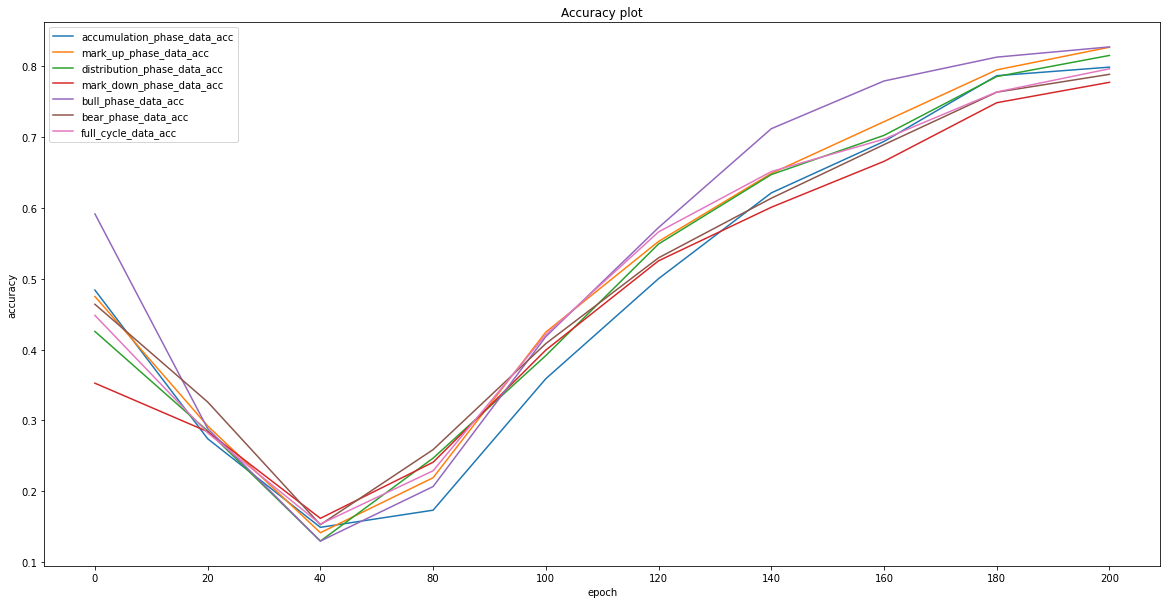

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

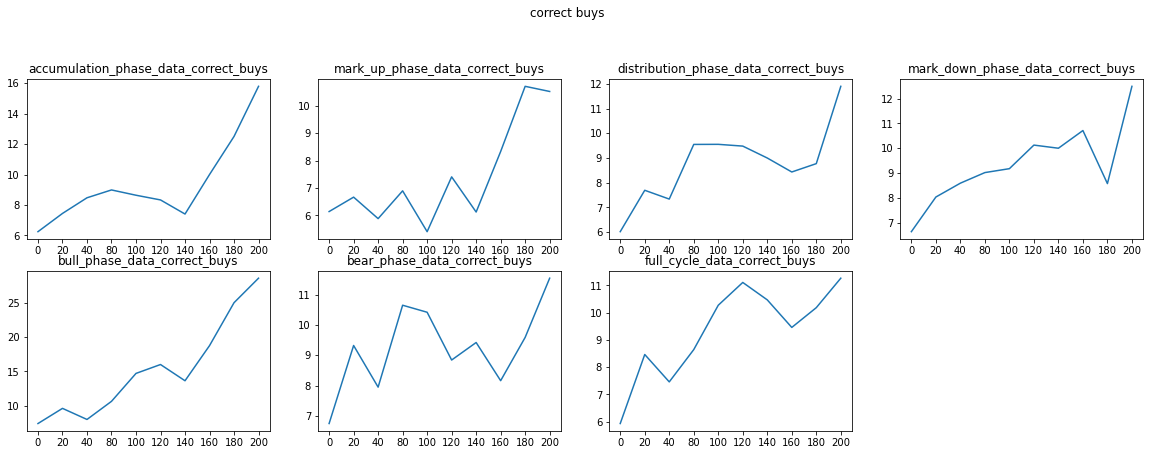

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

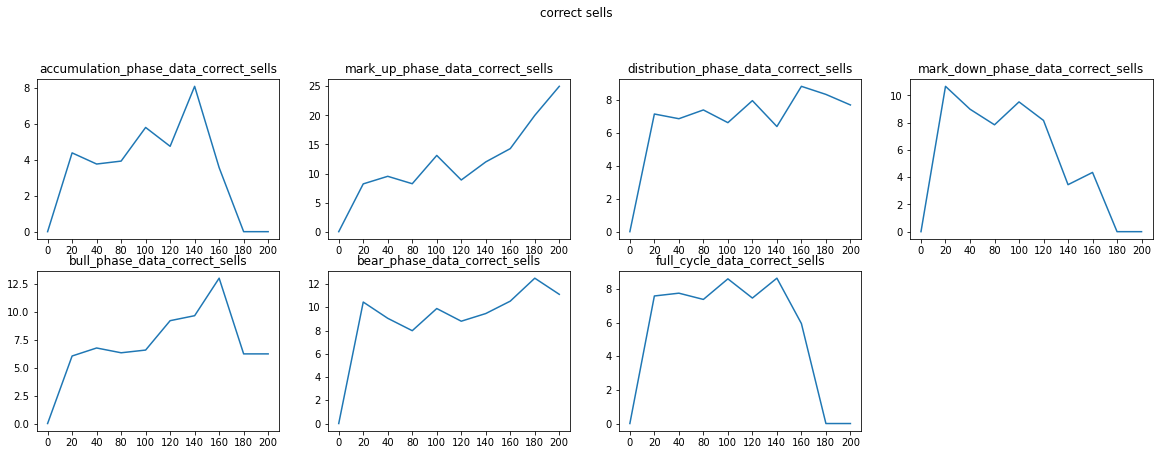

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

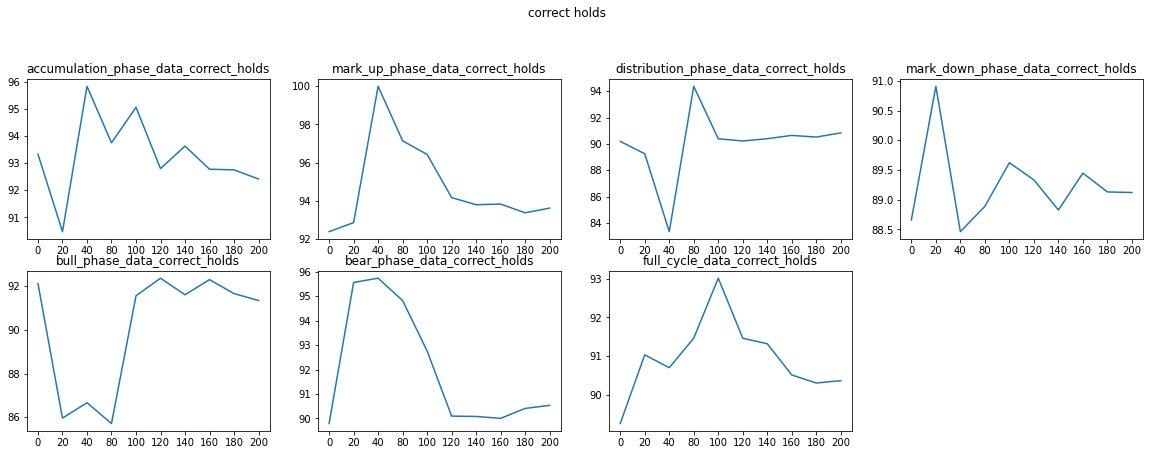

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

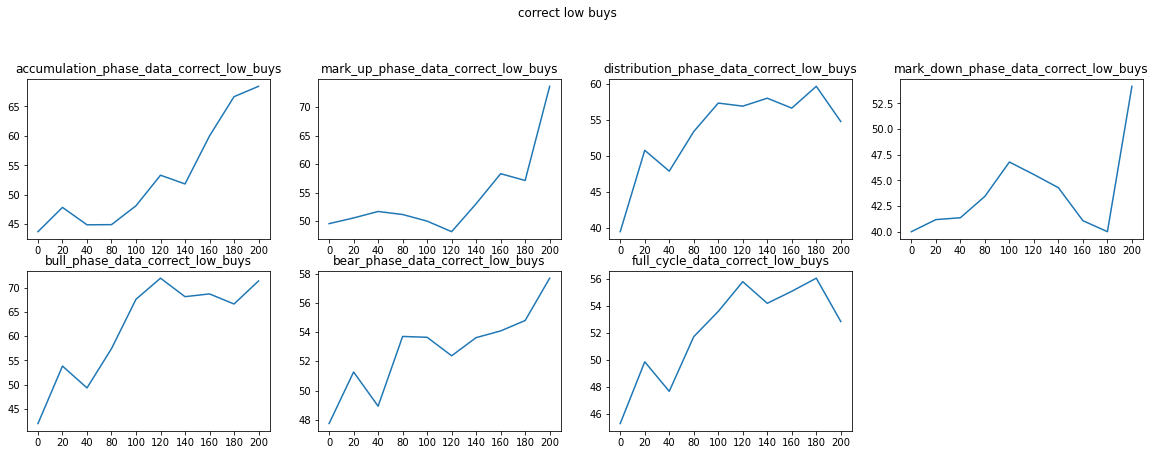

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

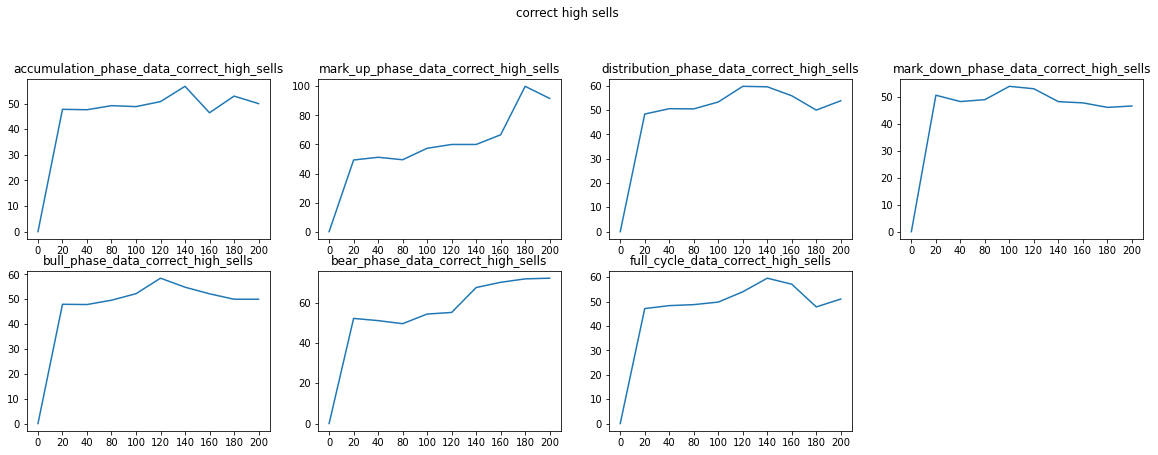

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

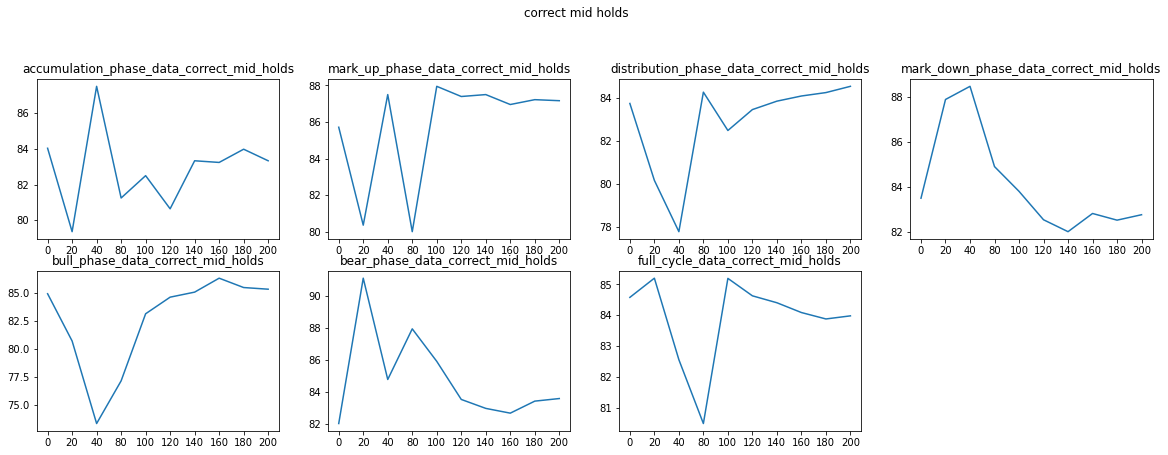

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

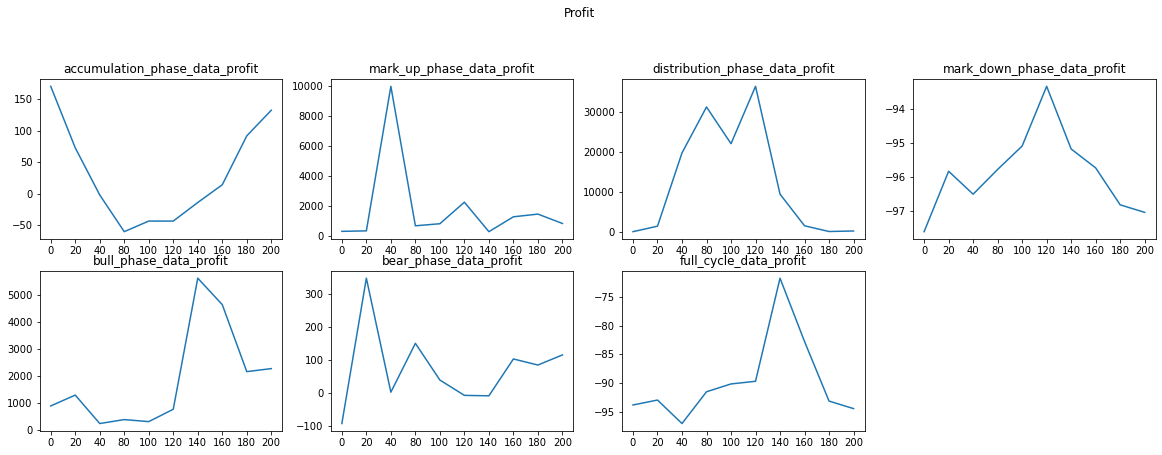

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")